# **Key Points To Cover**
* **Data**
* **Data Cleaning**
* **Data Split**
* **Evaluation Metric**
* **Impact of category Encoding (ham as 1 or spam as 1)**
* **Handing Imbalance data**
* **Chosing right probability threshold**
* **Where model went wrong**

In [1]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report

from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import string
import nltk
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
warnings.filterwarnings('ignore')
df = pd.read_csv("/kaggle/input/ham-spam1/ham_spam.csv", encoding='Windows-1252')
df.shape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(5572, 5)

In [ ]:
df.head()

In [2]:
df= df[['v1','v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Calculate length of each text by words

In [3]:
df['length'] = df['v2'].apply(lambda x: len(x.split()))
df.head()

,v1,v2,length
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


# Lets have look at few examples from spam category

In [4]:
row_count = 0
for row in df['v2'][df['v1']=='spam'].head(10):
    print(f"{row_count+1}: {row}")
    row_count+=1

1: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
2: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
3: WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
4: Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
5: SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info
6: URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
7: XXXMobileMovieClub: To use your credit, click the WAP link in the 

# examples from ham category

In [5]:
row_count = 0
for row in df['v2'][df['v1']=='ham'].head(10):
    print(f"{row_count+1}: {row}")
    row_count+=1

1: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
2: Ok lar... Joking wif u oni...
3: U dun say so early hor... U c already then say...
4: Nah I don't think he goes to usf, he lives around here though
5: Even my brother is not like to speak with me. They treat me like aids patent.
6: As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
7: I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
8: I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.
9: I HAVE A DATE ON SUNDAY WITH WILL!!
10: Oh k...i'm watching here:)


# Verify data points distribution

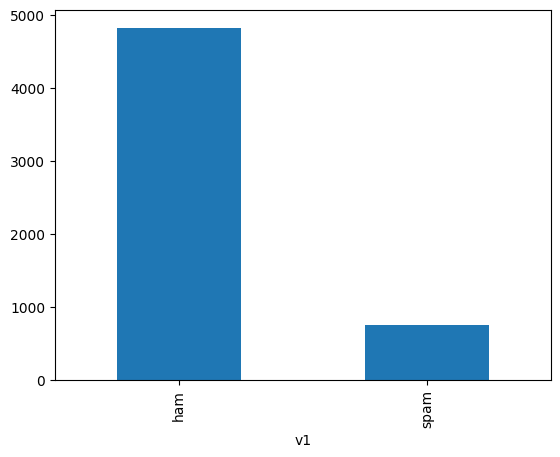

In [6]:
df['v1'].value_counts().plot(kind='bar')
plt.show()

# Above graph shows that data is highly imbalanced

# Below result shows that even if we build a model that every time predicts a text as ham, it will be correct 87% of the time

In [7]:
f"{(sum(df['v1'].values == 'ham')/len(df))*100:.2f}%"

'86.59%'

# Lets look at the distribution of number of words within each category(ham or spam)

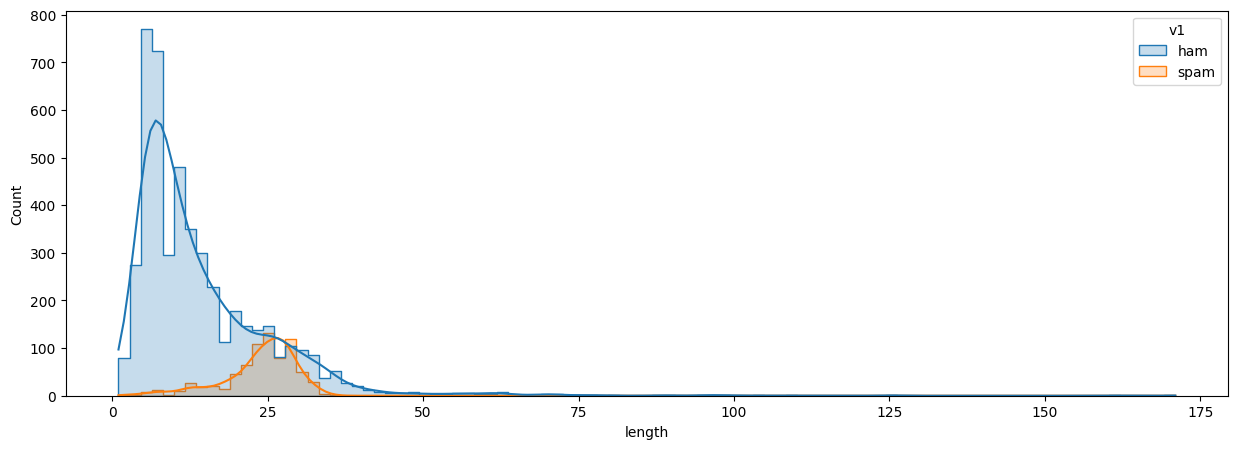

In [8]:
plt.figure(figsize=(15,5))
sns.histplot(data=df, x='length', kde=True, element="step", hue='v1')
plt.show()

# Distribution of word length changes depending upon a text belong to ham or spam. This could be an important feature if we chose to go with tradional ML models such as logistic regression or xgboost

# Lets check length statistic further

In [10]:
len_df = pd.DataFrame()
len_df['spam_length_stats'] = df['length'][df['v1']=='spam'].describe()
len_df['ham_length_stats'] = df['length'][df['v1']=='ham'].describe()
len_df

,spam_length_stats,ham_length_stats
count,747.000000,4825.000000
mean,23.851406,14.200622
std,5.811898,11.424511
min,2.000000,1.000000
25%,22.000000,7.000000
50%,25.000000,11.000000
75%,28.000000,19.000000
max,35.000000,171.000000


# Lets perform some preprocessing to identify patterns in ham or spam text. 

# Below code is removing any digit or special symbol, stop words and bringing every word in its root form by applying lemmatization

In [9]:
def clean_text(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', "", text) # Remove special characters, punctuation, and numbers
    text = re.sub(r"[\s]+", " ", text) # Remove multiple spaces with single space
    tokens = [token.lemma_ for token in nlp(text) if not token.is_stop] 
    cleaned_text = " ".join(tokens) # Join the tokens back into a cleaned text
    return cleaned_text

In [10]:
df['clean_text'] = df['v2'].apply(clean_text)

In [13]:
for index, row in df[['v2','clean_text']][df['v1']=='spam'].reset_index().head().iterrows():
    print(f"{index+1} Original Text:  {row['v2']}")
    print(f"{index+1} Cleaned Text:  {row['clean_text']}")

1 Original Text:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
1 Cleaned Text:  free entry wkly comp win fa cup final tkts st text fa receive entry questionstd txt ratetcs apply over
2 Original Text:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
2 Cleaned Text:  freemsg hey darle week word d like fun tb ok xxx std chgs send rcv
3 Original Text:  WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
3 Cleaned Text:  winner value network customer select receivea prize reward claim claim code kl valid hour
4 Original Text:  Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 0800298603

In [14]:
def plot_bar_graph(top_words, category):
    top_words, frequencies = zip(*top_words)

    plt.figure(figsize=(15, 6))
    plt.bar(top_words, frequencies, color='skyblue')

    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Most Frequent {category.upper()} Words')

    # Add annotations to the bars
    for i, freq in enumerate(frequencies):
        plt.text(i, freq, str(freq), ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=45, ha='right')
    plt.show()


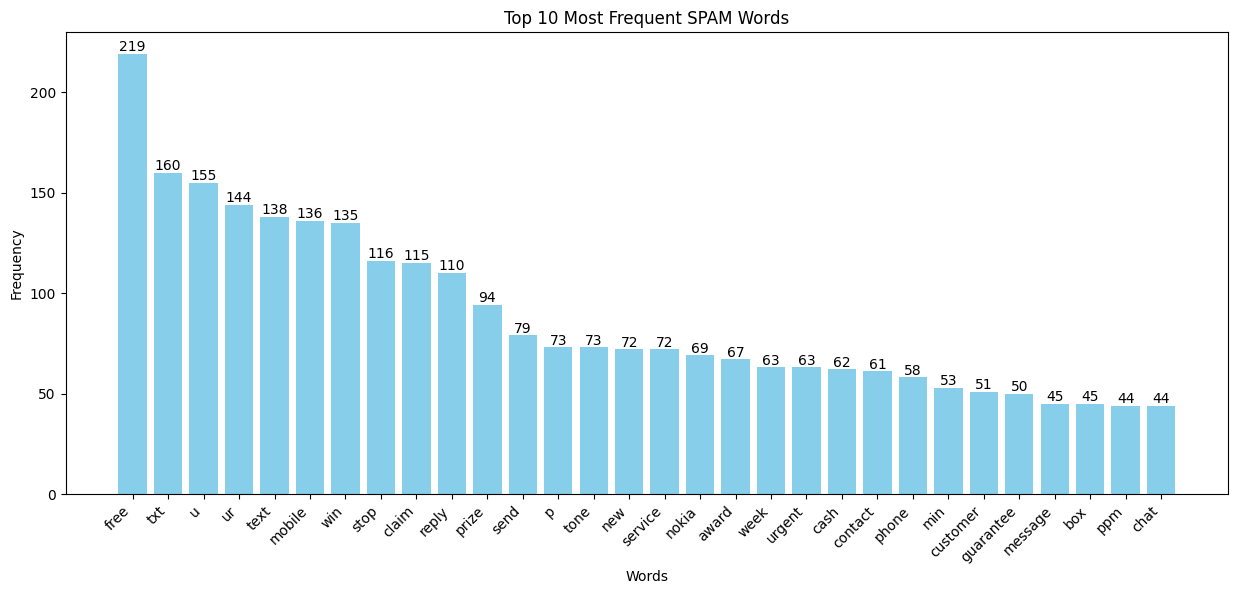

In [253]:
category = 'spam'
spam_all_text = " ".join(df['clean_text'][df['v1']==category]).split()
spam_word_freq = Counter(spam_all_text)
touple = spam_word_freq.most_common(30)
plot_bar_graph(touple, category)

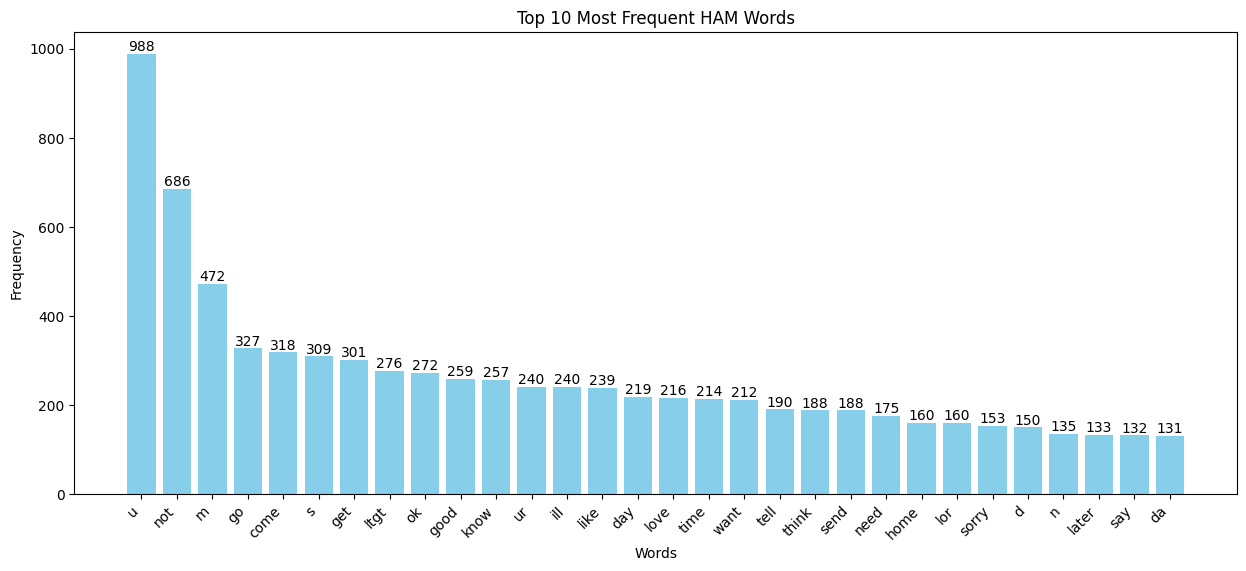

In [254]:
category = 'ham'
ham_all_text = " ".join(df['clean_text'][df['v1']==category]).split()
ham_word_freq = Counter(ham_all_text)
touple = ham_word_freq.most_common(30)
plot_bar_graph(touple, category)

# Lets verify how many unique words ham and spam have and among them how many words they share

In [255]:
print("total ham words: ",len(set(ham_all_text)))
print("total spam words: ",len(set(spam_all_text)))
print("total common words: ",len(set(ham_all_text).intersection(set(spam_all_text))))

total ham words:  6120
total spam words:  1902
total common words:  794


# Some of the common words are below

In [256]:
print(list(set(ham_all_text).intersection(set(spam_all_text)))[:100])

['couple', 've', 'correct', 'maybe', 'condition', 'community', 'chance', 'care', 'office', 'ta', 'plus', 'class', 'package', 'computer', 'em', 'last', 'fri', 'win', 'dirty', 'potential', 'news', 'hurry', 'morow', 'reveal', 'yesterday', 'unable', 'cam', 'careful', 'quiz', 'line', 'beg', 'survey', 'city', 'post', 'summer', 'normal', 'perfect', 'dot', 'pro', 'service', 'play', 'yo', 'completely', 'arrange', 'sex', 'accordingly', 'dis', 'street', 'activate', 'collect', 'till', 'sound', 'jst', 'dear', 'reference', 'th', 'ticket', 'claire', 'press', 'disaster', 'fall', 'k', 'jane', 'current', 'se', 'dark', 'nokia', 'uve', 'tomorrow', 'world', 'hubby', 'xxxxx', 'pix', 'n', 'adult', 'sport', 'drive', 'female', 'concert', 'woman', 'ya', 'yr', 'thur', 'door', 'energy', 'price', 'airport', 'question', 'film', 'fantastic', 'connection', 'dick', 'bedroom', 'pleased', 'goto', 'touch', 'auction', 'agent', 'hot', 'lover']


In [257]:

wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=300,
    contour_width=1,
    contour_color='steelblue'
)

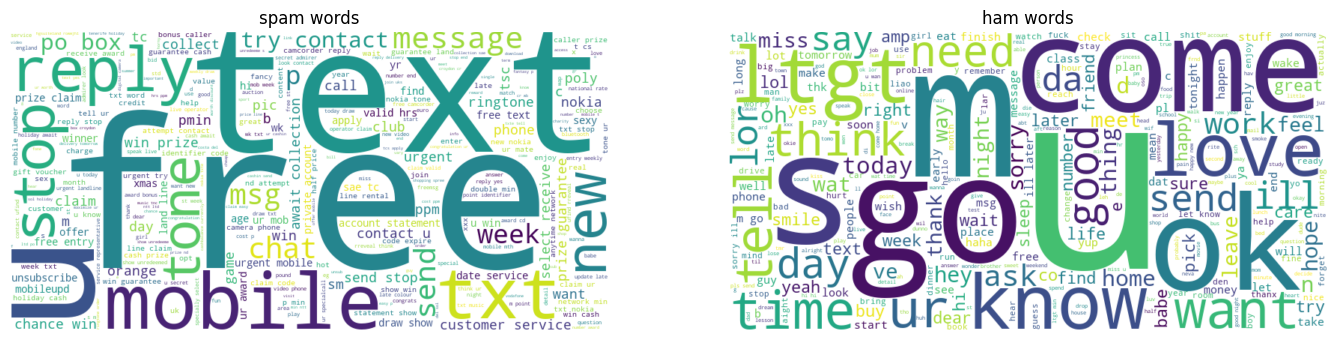

In [258]:
_, ax= plt.subplots(1,2,figsize=(17,7))
all_text = " ".join(df['clean_text'][df['v1']=='spam'])
# Generate and display the word cloud for all text combined
wordcloud.generate(all_text)

ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].set_title("spam words")
ax[0].axis('off')
###################################################

all_text = " ".join(df['clean_text'][df['v1']=='ham'])
# Generate and display the word cloud for all text combined
wordcloud.generate(all_text)

ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].set_title("ham words")

ax[1].axis('off')
plt.show()


# If you notice in above plot, words under spam cloud are very specific: such as Free, Mobile, Subscribe, ringtone, Prize, Win etc

# Whereas words under ham cloud are more general such as ok, will go, know, come etc.

# **Solution Approach**

# I will first start with a transformer based model like BERT, as these models are already trained on huge amount of data and can easily be finetuned on any down stream task as long as you have enough computation power.

# Later on i will be comparing BERT performnece with tradtinal ML algorithms such as Naive Bays, Lagistcic Regression, Xg Boost etc

# Eventually, I will be selecting the model which would give me the best F1-Score on test_set. Note that F1-Score in it self can vary greatly depending upon specific technique you use to calculate F1-Score. There are three variation of F1-Score

1. **F1_score with macro avaraging:**  It calculates f1-score for each class individually and then take average of all of them by giving equal weightage.
2. **F1_score with weighted avaraging:**  It calculates f1-score for each class individually and then take the weighted average of each class's f1-score
3. **F1_Score:** It claculates the f1 score for the positive class(the class which you have encoded as 1). Now this perticular technique very much depends on which class you have encoded as 1. For example: In this task if we encode ham as 1 then we will get a higher f1_score

# **I will be focusing on f1_score with macro averaging in this task**
* **Chossing the right metric to evaluate the models performence is the key in this project. Though i will be calculating accuracy, precision, recall and f1-score, but my focus would only be on f1-score.**

# **Data Split**

In [11]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
data = df[['v1','clean_text','v2','length']]
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['v1'])
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['v1'])

# Note that, as the data is imbalanced, we will have to split it in stratified way so that each of the train, val and test set have equal proportion of ham, spam data points.

# verify the proportion of data points in each set

In [12]:
# train set
spam_count = sum(train_data['v1'].values == 'spam')
ham_count = sum(train_data['v1'].values == 'ham')

total = spam_count + ham_count
spam_ration = spam_count/total
ham_ration = f'{ham_count/total:.2f}'
spam_ration = f'{spam_count/total:.2f}'
print(f"train_set: ham_ratio: {ham_ration}, spam_ratio: {spam_ration}, Total: {total}")
#######################################################
# validation set
spam_count = sum(val_data['v1'].values == 'spam')
ham_count = sum(val_data['v1'].values == 'ham')

total = spam_count + ham_count
spam_ration = spam_count/total
ham_ration = f'{ham_count/total:.2f}'
spam_ration = f'{spam_count/total:.2f}'
print(f"valid_set: ham_ratio: {ham_ration}  spam_ratio: {spam_ration}, Total: {total}")
#####################################################
# test_set
spam_count = sum(test_data['v1'].values == 'spam')
ham_count = sum(test_data['v1'].values == 'ham')

total = spam_count + ham_count
spam_ration = spam_count/total
ham_ration = f'{ham_count/total:.2f}'
spam_ration = f'{spam_count/total:.2f}'
print(f"test_set : ham_ratio: {ham_ration}  spam_ratio: {spam_ration}, Total: {total}")

train_set: ham_ratio: 0.87, spam_ratio: 0.13, Total: 4457
valid_set: ham_ratio: 0.87  spam_ratio: 0.13, Total: 558
test_set : ham_ratio: 0.87  spam_ratio: 0.13, Total: 557


# **BERT FineTunning.**

# Note that, to run below code you would need a GPU envoirenemnt. Otherwise it will take take very long to complete.

# Also BERT mostly does not require textual data cleaning. We just need to tokenize the input data and feed it inside the model for finetunning

In [16]:
max_len = 512
batch_size = 10

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name, from_pt=True)

bert_model.trainable = True

#Define the classification model
input_ids = Input(shape=(None,), name='input_ids', dtype=tf.int32)
attention_mask = Input(shape=(None,), name='attention_mask', dtype=tf.int32)
pooled_output = bert_model(input_ids, attention_mask).last_hidden_state[:,0,:]
outputs = Dense(1, activation='sigmoid')(pooled_output)
model = Model(inputs=[input_ids, attention_mask], outputs=outputs)


optimizer = Adam(learning_rate=.000001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

train_y_t = train_data['v1'].apply(lambda x: 0 if x=='ham' else 1)
val_y_t = val_data['v1'].apply(lambda x: 0 if x=='ham' else 1)

train_encodings = tokenizer(train_data['v2'].tolist(), truncation=True, padding=True, max_length=max_len)
val_encodings = tokenizer(val_data['v2'].tolist(), truncation=True, padding=True, max_length=max_len)

input_ids = train_encodings['input_ids']
attention_mask = train_encodings['attention_mask']
labels = train_y_t

oversampler = RandomOverSampler()

input_ids, y_trainn = oversampler.fit_resample(input_ids, labels)
attention_mask, y_trainn = oversampler.fit_resample(attention_mask, labels)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': input_ids, 'attention_mask': attention_mask},
    y_trainn
)).shuffle(len(train_encodings['input_ids'])).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    val_y_t
)).batch(batch_size)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=2,         
    restore_best_weights=True 
)

In [18]:
num_epochs = 6
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/6
772/772 [==============================] - 323s 364ms/step - loss: 0.1521 - accuracy: 0.9382 - val_loss: 0.0408 - val_accuracy: 0.9892
Epoch 2/6
772/772 [==============================] - 267s 346ms/step - loss: 0.0245 - accuracy: 0.9930 - val_loss: 0.0334 - val_accuracy: 0.9910
Epoch 3/6
772/772 [==============================] - 267s 346ms/step - loss: 0.0151 - accuracy: 0.9956 - val_loss: 0.0315 - val_accuracy: 0.9910
Epoch 4/6
772/772 [==============================] - 266s 344ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.0316 - val_accuracy: 0.9928
Epoch 5/6
772/772 [==============================] - 265s 344ms/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.0302 - val_accuracy: 0.9928
Epoch 6/6
772/772 [==============================] - 265s 344ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0319 - val_accuracy: 0.9928


# Calcuate other metrics on validation set

In [15]:
logits = []
for input_id, attention_mask in tqdm(zip(val_encodings['input_ids'], val_encodings['attention_mask'])):
    inputs = {
        'input_ids': tf.reshape(input_id, (1, -1)),
        'attention_mask': tf.reshape(attention_mask, (1, -1))
    }
    logit = model(inputs)
    logits.append(logit.numpy()[0])

558it [02:21,  3.96it/s]


In [16]:
y_pred_ = list(map(lambda x: 1 if x>0.5 else 0, logits))
score = {
'f1':[f1_score(val_y_t, y_pred_, average='macro')],
'precision':[precision_score(val_y_t, y_pred_, average='macro')],
'recall':[recall_score(val_y_t, y_pred_, average='macro')],
'accuracy':[accuracy_score(val_y_t, y_pred_)]
}

val_res = pd.DataFrame(score)
val_res.index = ['BERT']
val_res

,f1,precision,recall,accuracy
BERT,0.980636,0.983387,0.97793,0.991039


# Lets try to find out the right threshold

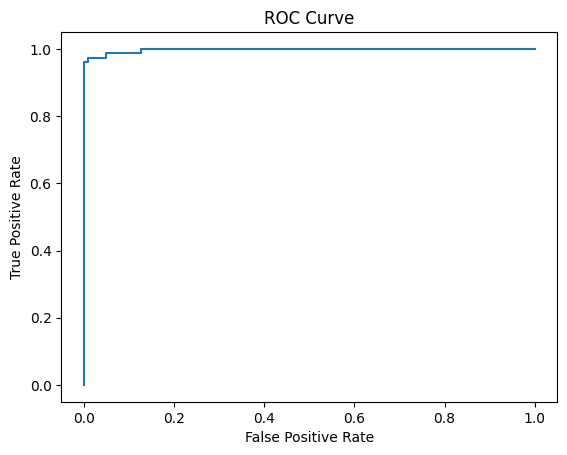

AUC value: 0.9975431331953072


In [17]:
from sklearn.metrics import roc_curve, auc, accuracy_score

y_score = [logit[0] for logit in logits]
fpr, tpr, thresholds = roc_curve(val_y_t, y_score)
auc_value = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
print("AUC value:", auc_value)

# Fetch best probablity threshold

In [19]:
best_threshold_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_idx]
best_threshold

0.2536753

In [22]:
y_pred_ = list(map(lambda x: 1 if x>0.50 else 0, logits))
score = {
'f1':[f1_score(val_y_t, y_pred_, average='macro')],
'precision':[precision_score(val_y_t, y_pred_, average='macro')],
'recall':[recall_score(val_y_t, y_pred_, average='macro')],
'accuracy':[accuracy_score(val_y_t, y_pred_)]
}

val_res = pd.DataFrame(score)
val_res.index = ['BERT']
val_res

,f1,precision,recall,accuracy
BERT,0.980636,0.983387,0.97793,0.991039


# Lets try to analyze where model went wrong

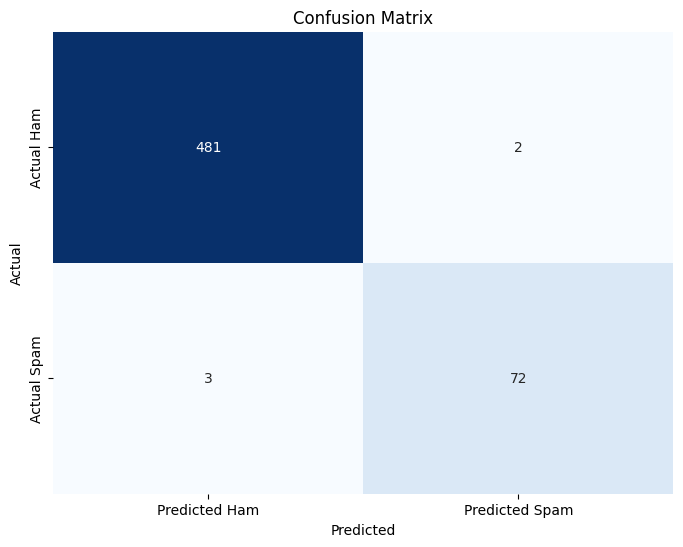

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y_t, y_pred_)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Text that are predicted as Ham, but they were actually Spam.

In [124]:
val_df = val_data['v2'].reset_index(drop=True)
val_y = val_y_t.reset_index(drop=True)
val_pred = pd.Series(y_pred_)

temp = val_df[(val_pred==0) & (val_y==1)]
for index in temp.index:
    #print(f"Original Text : {u_train[index]}")
    print(f"Text : {temp[index]}")
    print("="*150)

Text : Bought one ringtone and now getting texts costing 3 pound offering more tones etc
Text : RCT' THNQ Adrian for U text. Rgds Vatian
Text : Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?


# Text that are predicted as Spam, but they were actually Ham

In [125]:
val_df = val_data['v2'].reset_index(drop=True)
val_y = val_y_t.reset_index(drop=True)
val_pred = pd.Series(y_pred_)

temp = val_df[(val_pred==1) & (val_y==0)]
for index in temp.index:
    #print(f"Original Text : {u_train[index]}")
    print(f"Text : {temp[index]}")
    print("="*150)

Text : Somebody set up a website where you can play hold em using eve online spacebucks
Text : HCL chennai requires FRESHERS for voice process.Excellent english needed.Salary upto  &lt;#&gt; .Call Ms.Suman  &lt;#&gt;  for Telephonic interview -via Indyarocks.com


# Predict test set

In [77]:
test_encoding = tokenizer(test_data['v2'].tolist(), return_tensors='tf', padding=True, truncation=True)

logits = []
for input_id, attention_mask in tqdm(zip(test_encoding['input_ids'], test_encoding['attention_mask'])):
    inputs = {
        'input_ids': tf.reshape(input_id, (1, -1)),
        'attention_mask': tf.reshape(attention_mask, (1, -1))
    }
    logit = model(inputs)
    logits.append(logit.numpy()[0])

557it [01:47,  5.19it/s]


# Below is the performence on test set

In [78]:
y_pred_ = list(map(lambda x: 1 if x>0.25 else 0, logits))
y_test_ = test_data['v1'].apply(lambda x: 0 if x=='ham' else 1)

score = {
'f1':[f1_score(y_test_, y_pred_, average='macro')],
'precision':[precision_score(y_test_, y_pred_, average='macro')],
'recall':[recall_score(y_test_, y_pred_, average='macro')],
'accuracy':[accuracy_score(y_test_, y_pred_)]
}
res = pd.DataFrame(score)
res.index = ['BERT']
res

,f1,precision,recall,accuracy
BERT,0.980408,0.983202,0.977659,0.991023


In [79]:
print(classification_report(y_test_, y_pred_))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       483
           1       0.97      0.96      0.97        74

    accuracy                           0.99       557
   macro avg       0.98      0.98      0.98       557
weighted avg       0.99      0.99      0.99       557



* **BERT F1-Score with macro avaeraging on validation set = 0.98442**
* **BERT F1-Score with macro avaeraging on test set = 0.9804**

In [55]:
#model.save("spam_classifer.h5")
model_name = 'spam_classifer.h5'
model = tf.keras.models.load_model(model_name, custom_objects={"TFBertModel": transformers.TFBertModel})

In [133]:
test_encoding = tokenizer(["How are you"], return_tensors='tf', padding=True, truncation=True)

logits = []
for input_id, attention_mask in tqdm(zip(test_encoding['input_ids'], test_encoding['attention_mask'])):
    inputs = {
        'input_ids': tf.reshape(input_id, (1, -1)),
        'attention_mask': tf.reshape(attention_mask, (1, -1))
    }
    logit = model(inputs)
    logits.append(logit.numpy()[0])

logits

1it [00:00,  5.07it/s]


[array([0.00055919], dtype=float32)]

# Now lets explore ML Models and compare BERT performence with them

# Before apllying ML models, I have defiend few helper funtions which help us in preparing training validation and test data for experiment and calculating model's score on multiple occasion

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
scaler = MinMaxScaler()
def prepare_data(data, text_column = 'v2', label_column = 'v1', train_flag= False, length_flag = False):
    """
    Prepare the data for training, validation or testing. Note that this function is being called on multiple occasions. 
    If this will be called to prepare train data train_flag will be True so that we can call fit mathod of Tf-IDf and MixMax Scaler
    If this will be called with any dataset other than train, train_flag will be False so that direct tf-idf. min_max transformation is applied without fitting tf-idf and min_max on this new data
    if you want to include number of words feature in your dataset, you can enable length_flag parameter. this will add a new column in tf-idf matrix, otherwise only the TF-IDF matrix will be returned as X
    It maps spam values to 1 and ham values to 0.

    Parameters:
    - data (DataFrame): The input DataFrame containing text and labels.
    - text_column (str, optional): The name of the column containing text data. Defaults to 'v2'.
    - label_column (str, optional): The name of the column containing labels. Defaults to 'v1'.
    - train_flag (bool, optional): Flag indicating if preparing training data. Defaults to False. It signals if if-idf and minmax_scaler should be called
    - length_flag (bool, optional): Flag indicating if text length feature should be included. Defaults to False. It signals if the final prepared data will include text length column or not for training

    Returns:
    - prepared X, y for training
    """
    
    X, ys = data[text_column] ,data[label_column]
    if train_flag:
        tfidf_vectorizer.fit(X)
        scaler.fit(data[['length']])
    X = tfidf_vectorizer.transform(X)
    if length_flag:
        length = scaler.transform(data[['length']])
        X = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
        X['length'] = length
    
    y = [1 if y.lower() == 'spam' else 0 for y in ys]
    return X, y

In [30]:
def draw_comparision_graph(compare_results, text):
    """
    Draw a bar graph to compare F1-Scores of different models.
    Parameters:
    - compare_results: A DataFrame containing F1-Scores of different models.
    - text: Additional text for the graph title.
    """
    _,ax = plt.subplots(figsize=(10,5))
    compare_results.plot(kind='bar', ax=ax)
    plt.title(f'F1-Score comparision with and without data {text}')
    ax.set_xticklabels(compare_results.index, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
    
    ax.set_xlabel('Models')
    ax.set_ylabel('F1-Score')
    plt.show()

In [31]:
# Define custom scoring functions
def custom_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def custom_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro')

def custom_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average='macro')

def custom_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

scoring = {
    'accuracy': make_scorer(custom_accuracy),
    'precision': make_scorer(custom_precision),
    'recall': make_scorer(custom_recall),
    'f1': make_scorer(custom_f1)
}

def get_result(model, classifier, X_train, y_train):
    """
    Train a classifier on training data and evaluate its performance on validation data.
    Parameters:
    - model: Name or identifier for the model.
    - classifier: A classification model (exmaple: RandomForestClassifier, XGBClassifier).
    - X_train: Training data features.
    - y_train: True class labels for the training data.

    Returns:
    - result: A pandas DataFrame containing performance scores:
        - F1-Score (macro average)
        - Precision (macro average)
        - Recall (macro average)
        - Accuracy
    """
    scores = cross_validate(classifier, X_train, y_train, cv=stratified_kfold, scoring=scoring)

    result = pd.DataFrame({
    "f1": [np.mean(scores['test_f1'])],
    "precision": [np.mean(scores['test_precision'])],
    "recall": [np.mean(scores['test_recall'])],
    "accuracy": [np.mean(scores['test_accuracy'])],
    })
    result.index = [model]
    return result

def train_models(X_train, y_train, models_dict):
    """
    Train multiple classification models and evaluate their performance on validation data.
    Parameters:
    - X_train: Training data features.
    - y_train: True class labels for the training data.
    - models_dict: A dictionary containing model names (str) as keys and classification
      model estimators (estimator) as values.
    Returns:
    - models: A pandas DataFrame containing performance scores for each model:
        - F1-Score (macro average)
        - Precision (macro average)
        - Recall (macro average)
        - Accuracy
    """
    models = pd.DataFrame()
    for model, classifier in models_dict.items():
        result = get_result(model, classifier, X_train, y_train) # get_result funtion is defined just above this function
        models = pd.concat([models,result], axis=0)
    return models

# Below i am intitalizing models in such a way that they can handle imbalanced data

In [32]:
def initialize_models():
    """
    Initialize a dictionary of classification models with default hyperparameters.

    Returns:
    - models_dict: A dictionary containing model names (str) as keys and classification
      model estimators as values.
    """
    models_dict = dict()
    models_dict['XGBClassifier'] = xgb.XGBClassifier(random_state=42)
    models_dict['RandomForestClassifier'] = RandomForestClassifier(random_state=42, class_weight = 'balanced')
    models_dict['MultinomialNB'] = MultinomialNB(class_prior = [0.86580259222333, 0.13419740777667])
    models_dict['LogisticRegression'] = LogisticRegression(random_state=42, class_weight = 'balanced')
    return models_dict

# Lets start ,training models on raw data without any cleaning

# Though i am printing all the metric, but F1-Score is the one we should look at. Note that it may seem to you that f1-score is low, but I am using f1-score with macro averaging and this is why it is low. if i would have used weighted averaging the score whould have been higher.

In [33]:
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['v1'])
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['v1'])
train_data = shuffle(pd.concat([train_data,val_data]))
X_train, y_train = prepare_data(train_data, train_flag=True)
X_test, y_test  = prepare_data(test_data)

In [23]:
models = pd.DataFrame()
model_dict = initialize_models()
models = train_models(X_train, y_train, model_dict)
models

,f1,precision,recall,accuracy
XGBClassifier,0.950051,0.969116,0.933092,0.977667
RandomForestClassifier,0.949307,0.982053,0.922568,0.977866
MultinomialNB,0.957375,0.989531,0.930929,0.981456
LogisticRegression,0.967385,0.968194,0.966762,0.984845


# logistic regression has outperformed any other algorithm

# Training models with clean_text

In [24]:
X_train_clean, y_train = prepare_data(train_data, train_flag=True, text_column = 'clean_text')
X_test_clean, y_test  = prepare_data(test_data, text_column = 'clean_text')

cleaned_models = pd.DataFrame()
model_dict = initialize_models()
cleaned_models = train_models(X_train_clean, y_train, model_dict)
cleaned_models

,f1,precision,recall,accuracy
XGBClassifier,0.929091,0.957274,0.905427,0.968893
RandomForestClassifier,0.941576,0.981973,0.909535,0.974875
MultinomialNB,0.932357,0.979861,0.896179,0.971286
LogisticRegression,0.945049,0.945172,0.945084,0.974477


# data cleaning seem to have negative impact on model performence

# Lets compare model performence with and without cleaning

In [25]:
compare_results = pd.DataFrame()
compare_results['F1-Score without cleaning'] = models['f1']
compare_results['F1-Score with cleaned data'] = cleaned_models['f1']
compare_results

,F1-Score without cleaning,F1-Score with cleaned data
XGBClassifier,0.950051,0.929091
RandomForestClassifier,0.949307,0.941576
MultinomialNB,0.957375,0.932357
LogisticRegression,0.967385,0.945049


# Lets verify the impact of text length on model performence

In [418]:
X_train_with_len, y_train = prepare_data(train_data, train_flag=True, length_flag=True)
X_test_with_len, y_test  = prepare_data(test_data, length_flag=True)

length_models = pd.DataFrame()
model_dict = initialize_models()
length_models = train_models(X_train_with_len, y_train, model_dict)
length_models

,f1,precision,recall,accuracy
XGBClassifier,0.953134,0.972589,0.935830,0.979063
RandomForestClassifier,0.948889,0.980111,0.923077,0.977667
MultinomialNB,0.955616,0.988348,0.928558,0.980658
LogisticRegression,0.969529,0.969861,0.969237,0.985842


# text length does not seem to have much impact

# **Lets perform Parameter Tunning.**

In [409]:
X_train, y_train = prepare_data(train_data, train_flag=True)

In [363]:
models_param_dict = dict()
 

models_param_dict['XGBClassifier'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.2, 0.3],
     'max_depth': [3, 5]
}


models_param_dict['RandomForestClassifier'] = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None ,5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3],
}


models_param_dict['MultinomialNB'] = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
}


models_param_dict['LogisticRegression'] = {
    'C': [0.1, 1.0, 10.0, 50.0, 150,200],
}

In [364]:
def tune_parameters(classifier, param_grid, model, X_train, y_train):
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='f1_macro', cv=stratified_kfold)
    grid_search.fit(X_train, y_train)
    result = pd.DataFrame()
    result['f1_marco'] = [grid_search.best_score_]
    result['best_params'] = [grid_search.best_params_]
    result['best_estimator'] = [grid_search.best_estimator_]
    result.index = [model]
    return result

In [365]:
tuned_models = pd.DataFrame()
model_dict = initialize_models()
for model, classifier in  model_dict.items():
    result = tune_parameters(classifier, models_param_dict[model], model, X_train, y_train)
    tuned_models = pd.concat([tuned_models,result])
tuned_models

,f1_marco,best_params,best_estimator
XGBClassifier,0.954902,"{'learning_rate': 0.3, 'max_depth': 5, 'n_esti...","XGBClassifier(base_score=None, booster=None, c..."
RandomForestClassifier,0.963304,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...","(DecisionTreeClassifier(max_features='sqrt', m..."
MultinomialNB,0.968349,{'alpha': 0.1},MultinomialNB(alpha=0.1)
LogisticRegression,0.973522,{'C': 10.0},"LogisticRegression(C=10.0, class_weight='balan..."


# After fine tunning LogisticRegression has outperformed any other algorithm with 0.973 f1 score and this is the best score that we have seen so far with any ML model.

# I will select logistc regressiion as the final model and check its performence on test set

# Now finally verify LogisticRegression performence on test set

In [26]:
logistic_regression_classifier = LogisticRegression(random_state=42, C=10, class_weight = 'balanced')
logistic_regression_classifier.fit(X_train, y_train)
pred = logistic_regression_classifier.predict(X_test)

In [27]:
score = {
'f1':[f1_score(y_test, pred, average='macro')],
'precision':[precision_score(y_test, pred, average='macro')],
'recall':[recall_score(y_test, pred, average='macro')],
'accuracy':[accuracy_score(y_test, pred)]
}
final_res = pd.DataFrame(score)
final_res.index = ['LogisticRegression']
final_res

,f1,precision,recall,accuracy
LogisticRegression,0.952148,0.963215,0.941805,0.978456


# Logistic model has done decent job, but it is not as good as BERT

In [30]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       483
           1       0.94      0.89      0.92        74

    accuracy                           0.98       557
   macro avg       0.96      0.94      0.95       557
weighted avg       0.98      0.98      0.98       557



# **Conclusion**
* BERT model has outperformed any other model with 0.974 F1-Score with macro averaging
* Logistic regression has done decent job

**# Note that there are already pretrained models for Ham or Spam classifer available on Hugging Face, We could use any of them directly wihout any preprocessing. Below is an example:

https://huggingface.co/jg/distilbert-base-uncased-finetuned-spam